#MovieLens 2019-12 data to predict movies score
***
author: Joe Lin (林邑泉)

description: using 201912 data from <a href="https://grouplens.org/datasets/movielens/">https://grouplens.org/datasets/movielens/</a> predict movies score
***


##Google Colab Preparation 

In [118]:
from google.colab import drive
drive.mount('/content/drive')
data_folder = '/content/drive/My Drive/Colab Notebooks/201912Movielen/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Preprocessing

###Import Library and default setting

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
import warnings

warnings.filterwarnings('ignore')

###Read data and data analysize

In [120]:
#read csv data as dataframe in pandas
rating_df = pd.read_csv(data_folder+'ratings.csv', encoding='utf-8')

#print number of listing.
print(f"The dataset contains {len(rating_df)} data")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

#print listing feature, type and how many non-null data 
print(rating_df.info())
print(rating_df.describe())
#print the data from 0 to 2
rating_df.head(3)

The dataset contains 25000095 data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB
None
             userId       movieId        rating     timestamp
count  2.500010e+07  2.500010e+07  2.500010e+07  2.500010e+07
mean   8.118928e+04  2.138798e+04  3.533854e+00  1.215601e+09
std    4.679172e+04  3.919886e+04  1.060744e+00  2.268758e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    4.051000e+04  1.196000e+03  3.000000e+00  1.011747e+09
50%    8.091400e+04  2.947000e+03  3.500000e+00  1.198868e+09
75%    1.215570e+05  8.623000e+03  4.000000e+00  1.447205e+09
max    1.625410e+05  2.091710e+05  5.000000e+00  1.574328e+09


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828


##Data preparing

###Reduce data and keep the recently data  

In [121]:
rating_df = rating_df[rating_df.timestamp > 1530205000]
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1906988 entries, 299 to 24999522
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 72.7 MB


###Separate feature and answer

In [136]:
from sklearn.preprocessing import StandardScaler

# Separate X(feature) and y(answer)
X = rating_df.drop(['rating','timestamp'], axis=1)
Y = rating_df.rating



In [137]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1906988 entries, 299 to 24999522
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 43.6 MB


###Traing and testing data generate

In [138]:
from sklearn.model_selection import train_test_split

traing_data = {'x':[],'y':[]}
testing_data = {'x':[],'y':[]}

#because of limitation memory, only prepare one dataset
data_set_len = 1
for index in range(data_set_len):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=index)
  traing_data['x'].append(X_train)
  traing_data['y'].append(Y_train)
  testing_data['x'].append(X_test)
  testing_data['y'].append(Y_test)

del X_train,X_test,Y_train,Y_test

##Modeling

###Presetting

In [139]:
def Ave(lst): 
  return sum(lst) / len(lst) 

Total_result = {}

###Model 1: Non-negative Matrix Factorization


In [140]:
import random
import scipy.sparse as sps
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error, r2_score

def dict_creater(input_list):
  output_dict = {}
  for i in range(len(input_list)):
    output_dict[input_list[i]] = i
  return output_dict

def rating_predict(userId,movieId,W,HT):
  prediction = np.dot(W[userId_to_row_dict[userId]], HT[movieId_to_col_dict[movieId]].T)
  return prediction

userId_set = list(set(rating_df['userId']))
movieId_set = list(set(rating_df['movieId']))
user_num = len(userId_set)
movie_num = len(movieId_set)

random.shuffle(userId_set)
random.shuffle(movieId_set)

userId_to_row_dict = dict_creater(userId_set)
movieId_to_col_dict = dict_creater(movieId_set)    

algorithm = 'Non-negative Matrix Factorization'
print(algorithm)
result = {'training':{'MSE':[],'r2':[],'time':[]},'testing':{'MSE':[],'r2':[],'time':[]}}
for index in range(data_set_len):
  matrix = sps.lil_matrix((user_num,movie_num), dtype = np.float16)  
  start = time.time()
  x = traing_data['x'][index]
  y = traing_data['y'][index]
  for data_index, row in x.iterrows():
    matrix[userId_to_row_dict[row['userId']], movieId_to_col_dict[row['movieId']]] = y.loc[data_index]


  n_components = 100
  model = NMF(n_components = n_components, init= 'random', max_iter = 100)
  W = model.fit_transform(matrix)
  H = model.components_
  HT = H.T
  del model,matrix


  training_pred=[]
  for data_index, row in x.iterrows():
    training_pred.append(rating_predict(row['userId'], row['movieId'],W,HT))
  result['training']['MSE'].append(round(mean_squared_error(y, training_pred),4))
  result['training']['r2'].append(round(r2_score(y, training_pred),4))
  result['training']['time'].append(round((time.time() - start),1))

  
  #testing  
  start = time.time()
  x = testing_data['x'][index]
  y = testing_data['y'][index]
  testing_pred=[]
  for data_index, row in x.iterrows():
    testing_pred.append(rating_predict(row['userId'], row['movieId'],W,HT))
  result['testing']['MSE'].append(round(mean_squared_error(y, testing_pred),4))
  result['testing']['r2'].append(round(r2_score(y, testing_pred),4))
  result['testing']['time'].append(round((time.time() - start),1))

  temp_x = x[:5]
  temp_y = y[:5]
  for data_index, row in temp_x.iterrows():
    print(index,data_index,rating_predict(row['userId'], row['movieId'],W,HT),temp_y.loc[data_index])

  del temp_x,temp_y
  

Total_result.update({algorithm:{}})
for data in result:
  Total_result[algorithm].update({data:{}})
  print(data,":")
  for measure in result[data]:
    avg = Ave(result[data][measure])
    Total_result[algorithm][data].update({measure:avg})
    print(measure,avg)


del userId_to_row_dict,movieId_to_col_dict,W,H,HT

Non-negative Matrix Factorization
0 24230981 0.5090080328156543 4.0
0 23719477 0.10021613562715084 4.0
0 2183622 0.02114090621471658 3.5
0 4989927 0.24673674749431232 4.0
0 15894606 0.8427823833221988 5.0
training :
MSE 6.9024
r2 -5.1122
time 537.5
testing :
MSE 9.1619
r2 -7.0937
time 44.8


###Label data for Neural Network

In [141]:
from sklearn.preprocessing import LabelEncoder

for index in range(data_set_len):
  final_df = pd.concat([traing_data['x'][index], testing_data['x'][index]]) 
  userId_dummy_created = LabelEncoder().fit_transform(final_df['userId'])
  movieId_dummy_created = LabelEncoder().fit_transform(final_df['movieId'])
  X_train_user, X_test_user = train_test_split(userId_dummy_created, test_size=0.2,shuffle=False)
  X_train_movie, X_test_movie = train_test_split(movieId_dummy_created, test_size=0.2,shuffle=False)

  traing_data['x'][index] = [X_train_user,X_train_movie]
  testing_data['x'][index] = [X_test_user,X_test_movie]


del X_train_user,X_test_user,X_train_movie,X_test_movie,final_df,userId_dummy_created,movieId_dummy_created

###Model 2: Matrix Factorization base on Neural Network

Model: "functional_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 100)       1457700     user[0][0]                       
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 100)       4698800     movie[0][0]                      
______________________________________________________________________________________

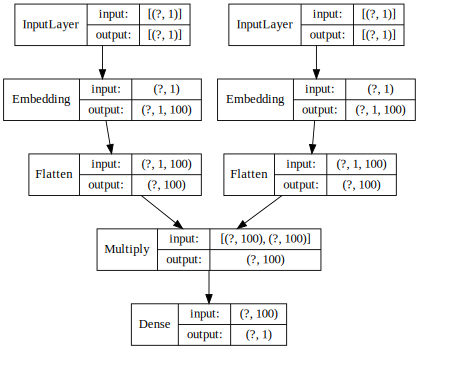

In [142]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, concatenate, Flatten, Activation, Add, Dropout, Multiply
from keras.optimizers import Adam
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#network setting

# user input
user_input = Input(1,name='user')
user_hidden = Embedding(input_dim=user_num, output_dim=n_components,name='user_embedding')(user_input)
user_hidden = Flatten()(user_hidden)

# movie input
movie_input = Input(1,name='movie')
movie_hidden = Embedding(input_dim=movie_num, output_dim=n_components,name='movie_embedding')(movie_input)
movie_hidden = Flatten()(movie_hidden)

# element-wise multiplication
hidden = Multiply()([user_hidden, movie_hidden])
#hidden = user_hidden*movie_hidden

output = Dense(1, activation='linear')(hidden)

model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.005),metrics=['mean_squared_error'])


print(model.summary())

SVG(model_to_dot(model, show_layer_names=False, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [143]:
import tensorflow as tf

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor = 'val_loss'),]


algorithm = 'Matrix Factorization'
print(algorithm)
result = {'training':{'MSE':[],'r2':[],'time':[]},'testing':{'MSE':[],'r2':[],'time':[]}}
for index in range(data_set_len):
  #training
  start = time.time()

  x = traing_data['x'][index]
  y = traing_data['y'][index]
  model.fit(x,y,epochs=100,batch_size=2048,validation_split = 0.1,callbacks=my_callbacks)
  training_pred = model.predict(x)
  result['training']['MSE'].append(round(mean_squared_error(y, training_pred),4))
  result['training']['r2'].append(round(r2_score(y, training_pred),4))
  result['training']['time'].append(round((time.time() - start),1))
  
  #testing  
  start = time.time()
  x = testing_data['x'][index]
  y = testing_data['y'][index]
  testing_pred = model.predict(x)
  result['testing']['MSE'].append(round(mean_squared_error(y, testing_pred),4))
  result['testing']['r2'].append(round(r2_score(y, testing_pred),4))
  result['testing']['time'].append(round((time.time() - start),1))

  for data_index in range(5):
    print(index,data_index,testing_pred[data_index],y.iloc[data_index])

  '''
  for data in result:
    print(index,data)
    for measure in result[data]:
      print(measure,result[data][measure][index])
  '''

Total_result.update({algorithm:{}})
for data in result:
  Total_result[algorithm].update({data:{}})
  print(data,":")
  for measure in result[data]:
    avg = Ave(result[data][measure])
    Total_result[algorithm][data].update({measure:avg})
    print(measure,avg)


Matrix Factorization
Epoch 1/100
671/671 [==============================] - 25s 37ms/step - loss: 2.8106 - mean_squared_error: 2.8106 - val_loss: 0.8092 - val_mean_squared_error: 0.8092
Epoch 2/100
671/671 [==============================] - 24s 36ms/step - loss: 0.6039 - mean_squared_error: 0.6039 - val_loss: 0.7361 - val_mean_squared_error: 0.7361
Epoch 3/100
671/671 [==============================] - 25s 37ms/step - loss: 0.4112 - mean_squared_error: 0.4112 - val_loss: 0.7375 - val_mean_squared_error: 0.7375
Epoch 4/100
671/671 [==============================] - 25s 37ms/step - loss: 0.3082 - mean_squared_error: 0.3082 - val_loss: 0.7518 - val_mean_squared_error: 0.7518
Epoch 5/100
671/671 [==============================] - 25s 37ms/step - loss: 0.2502 - mean_squared_error: 0.2502 - val_loss: 0.7651 - val_mean_squared_error: 0.7651
0 0 [2.9466972] 4.0
0 1 [4.354489] 4.0
0 2 [3.4199924] 3.5
0 3 [3.2551599] 4.0
0 4 [4.463199] 5.0
training :
MSE 0.2442
r2 0.7837
time 150.1
testing :
MSE

###Model 3:Multilayer perceptron

Model: "functional_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 100)       1457700     user[0][0]                       
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 100)       4698800     movie[0][0]                      
______________________________________________________________________________________

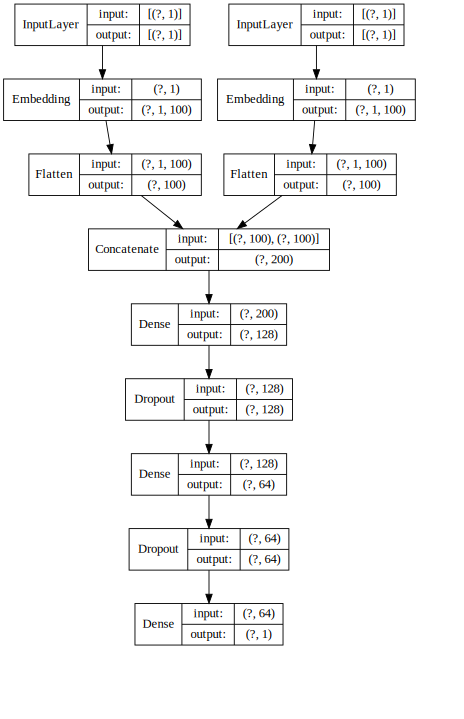

In [144]:
#network setting

# user input
user_input = Input(1,name='user')
user_hidden = Embedding(input_dim=user_num, output_dim=n_components,name='user_embedding')(user_input)
user_hidden = Flatten()(user_hidden)

# movie input
movie_input = Input(1,name='movie')
movie_hidden = Embedding(input_dim=movie_num, output_dim=n_components,name='movie_embedding')(movie_input)
movie_hidden = Flatten()(movie_hidden)

#multilayer perceptron
hidden = concatenate([user_hidden, movie_hidden])
hidden = Dense(128, activation='relu')(hidden)
hidden = Dropout(0.2)(hidden)
hidden = Dense(64, activation='relu')(hidden)    
hidden = Dropout(0.2)(hidden)    

output = Dense(1, activation='linear')(hidden)

model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.005),metrics=['mean_squared_error'])


print(model.summary())

SVG(model_to_dot(model, show_layer_names=False, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [145]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor = 'val_loss'),]


algorithm = 'Multilayer perceptron'
print(algorithm)
result = {'training':{'MSE':[],'r2':[],'time':[]},'testing':{'MSE':[],'r2':[],'time':[]}}
for index in range(data_set_len):
  #training
  start = time.time()

  x = traing_data['x'][index]
  y = traing_data['y'][index]
  model.fit(x,y,epochs=100,batch_size=2048,validation_split = 0.1,callbacks=my_callbacks)
  training_pred = model.predict(x)
  result['training']['MSE'].append(round(mean_squared_error(y, training_pred),4))
  result['training']['r2'].append(round(r2_score(y, training_pred),4))
  result['training']['time'].append(round((time.time() - start),1))
  
  #testing  
  start = time.time()
  x = testing_data['x'][index]
  y = testing_data['y'][index]
  testing_pred = model.predict(x)
  result['testing']['MSE'].append(round(mean_squared_error(y, testing_pred),4))
  result['testing']['r2'].append(round(r2_score(y, testing_pred),4))
  result['testing']['time'].append(round((time.time() - start),1))

  for data_index in range(5):
    print(index,data_index,testing_pred[data_index],y.iloc[data_index])

  '''
  for data in result:
    print(index,data)
    for measure in result[data]:
      print(measure,result[data][measure][index])
  '''

Total_result.update({algorithm:{}})
for data in result:
  Total_result[algorithm].update({data:{}})
  print(data,":")
  for measure in result[data]:
    avg = Ave(result[data][measure])
    Total_result[algorithm][data].update({measure:avg})
    print(measure,avg)


Multilayer perceptron
Epoch 1/100
671/671 [==============================] - 36s 53ms/step - loss: 0.9761 - mean_squared_error: 0.9761 - val_loss: 0.6902 - val_mean_squared_error: 0.6902
Epoch 2/100
671/671 [==============================] - 35s 52ms/step - loss: 0.7354 - mean_squared_error: 0.7354 - val_loss: 0.6653 - val_mean_squared_error: 0.6653
Epoch 3/100
671/671 [==============================] - 35s 52ms/step - loss: 0.6824 - mean_squared_error: 0.6824 - val_loss: 0.6564 - val_mean_squared_error: 0.6564
Epoch 4/100
671/671 [==============================] - 35s 52ms/step - loss: 0.6352 - mean_squared_error: 0.6352 - val_loss: 0.6431 - val_mean_squared_error: 0.6431
Epoch 5/100
671/671 [==============================] - 35s 52ms/step - loss: 0.5929 - mean_squared_error: 0.5929 - val_loss: 0.6337 - val_mean_squared_error: 0.6337
Epoch 6/100
671/671 [==============================] - 35s 52ms/step - loss: 0.5591 - mean_squared_error: 0.5591 - val_loss: 0.6291 - val_mean_squared_er

###Model 4:NeuralCF

Model: "functional_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 100)       1457700     user[0][0]                       
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 100)       4698800     movie[0][0]                      
______________________________________________________________________________________

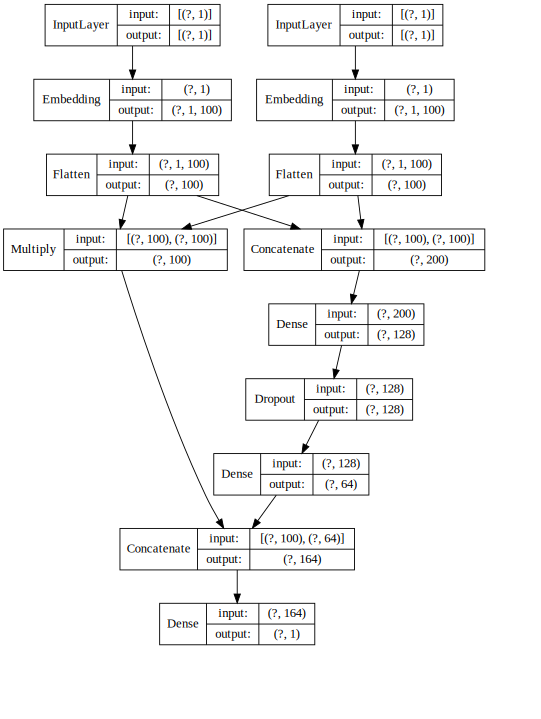

In [146]:
#network setting
# user input
user_input = Input(1,name='user')
user_hidden = Embedding(input_dim=user_num, output_dim=n_components,name='user_embedding')(user_input)
user_hidden = Flatten()(user_hidden)

# movie input
movie_input = Input(1,name='movie')
movie_hidden = Embedding(input_dim=movie_num, output_dim=n_components,name='movie_embedding')(movie_input)
movie_hidden = Flatten()(movie_hidden)


# element-wise multiplication
gmf_output = Multiply()([user_hidden, movie_hidden])

#multilayer perceptron
hidden = concatenate([user_hidden, movie_hidden])
hidden = Dense(128, activation='relu')(hidden)
hidden = Dropout(0.2)(hidden)
mlp_output = Dense(64, activation='relu')(hidden) 

output = concatenate([gmf_output, mlp_output])
output = Dense(1, activation='linear')(output)

model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.005),metrics=['mean_squared_error'])


print(model.summary())

SVG(model_to_dot(model, show_layer_names=False, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [147]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor = 'val_loss'),]


algorithm = 'NeuralCF'
print(algorithm)
result = {'training':{'MSE':[],'r2':[],'time':[]},'testing':{'MSE':[],'r2':[],'time':[]}}
for index in range(data_set_len):
  #training
  start = time.time()

  x = traing_data['x'][index]
  y = traing_data['y'][index]
  model.fit(x,y,epochs=100,batch_size=2048,validation_split = 0.1,callbacks=my_callbacks)
  training_pred = model.predict(x)
  result['training']['MSE'].append(round(mean_squared_error(y, training_pred),4))
  result['training']['r2'].append(round(r2_score(y, training_pred),4))
  result['training']['time'].append(round((time.time() - start),1))
  
  #testing  
  start = time.time()
  x = testing_data['x'][index]
  y = testing_data['y'][index]
  testing_pred = model.predict(x)
  result['testing']['MSE'].append(round(mean_squared_error(y, testing_pred),4))
  result['testing']['r2'].append(round(r2_score(y, testing_pred),4))
  result['testing']['time'].append(round((time.time() - start),1))

  for data_index in range(5):
    print(index,data_index,testing_pred[data_index],y.iloc[data_index])

  '''
  for data in result:
    print(index,data)
    for measure in result[data]:
      print(measure,result[data][measure][index])
  '''

Total_result.update({algorithm:{}})
for data in result:
  Total_result[algorithm].update({data:{}})
  print(data,":")
  for measure in result[data]:
    avg = Ave(result[data][measure])
    Total_result[algorithm][data].update({measure:avg})
    print(measure,avg)


NeuralCF
Epoch 1/100
671/671 [==============================] - 37s 55ms/step - loss: 0.9330 - mean_squared_error: 0.9330 - val_loss: 0.6820 - val_mean_squared_error: 0.6820
Epoch 2/100
671/671 [==============================] - 34s 51ms/step - loss: 0.6566 - mean_squared_error: 0.6566 - val_loss: 0.6806 - val_mean_squared_error: 0.6806
Epoch 3/100
671/671 [==============================] - 35s 52ms/step - loss: 0.5556 - mean_squared_error: 0.5556 - val_loss: 0.6982 - val_mean_squared_error: 0.6982
Epoch 4/100
671/671 [==============================] - 35s 52ms/step - loss: 0.4247 - mean_squared_error: 0.4247 - val_loss: 0.6730 - val_mean_squared_error: 0.6730
Epoch 5/100
671/671 [==============================] - 35s 52ms/step - loss: 0.3289 - mean_squared_error: 0.3289 - val_loss: 0.6932 - val_mean_squared_error: 0.6932
Epoch 6/100
671/671 [==============================] - 35s 51ms/step - loss: 0.2675 - mean_squared_error: 0.2675 - val_loss: 0.7520 - val_mean_squared_error: 0.7520
E

#Result

In [148]:
rows_list = []
for algorithm in Total_result:
  for state in Total_result[algorithm]:
    rows_list.append([algorithm,state,Total_result[algorithm][state]['MSE'],Total_result[algorithm][state]['r2'],Total_result[algorithm][state]['time']]) 
result_df = pd.DataFrame(rows_list,columns =['algorithm', 'state','MSE','r2','time']) 
result_df

,algorithm,state,MSE,r2,time
0,Non-negative Matrix Factorization,training,6.9024,-5.1122,537.5
1,Non-negative Matrix Factorization,testing,9.1619,-7.0937,44.8
2,Matrix Factorization,training,0.2442,0.7837,150.1
3,Matrix Factorization,testing,0.7675,0.3220,6.5
4,Multilayer perceptron,training,0.3708,0.6717,524.1
5,Multilayer perceptron,testing,0.6264,0.4466,7.8
6,NeuralCF,training,0.2256,0.8002,278.3
7,NeuralCF,testing,0.7281,0.3568,7.9


(6.9024, 0.2442, 0.3708, 0.2256)
(9.1619, 0.7675, 0.6264, 0.7281)


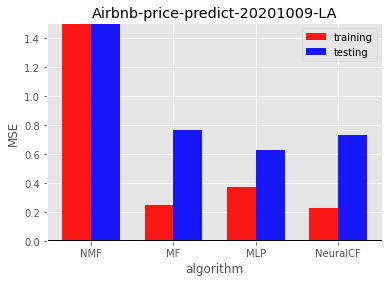

In [154]:
plt.style.use('ggplot')
n = 4

measure = 'MSE'
train_result= tuple(result_df[result_df['state']=='training'][measure])
test_result = tuple(result_df[result_df['state']=='testing'][measure])
print(train_result)
print(test_result)


fig, ax = plt.subplots()
index = np.arange(n)
bar_width = 0.35
opacity = 0.9
ax.bar(index, train_result, bar_width, alpha=opacity, color='r',label='training')

ax.bar(index+bar_width, test_result, bar_width, alpha=opacity, color='b',
                label='testing')
ax.set_ylim([0,1.5])
ax.set_xlabel('algorithm')
ax.set_ylabel(measure)
ax.set_title('Airbnb-price-predict-20201009-LA')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('NMF','MF','MLP','NeuralCF'))
ax.axhline(y=0.0, color='black', linestyle='-', linewidth=2)
ax.legend()
plt.show()

##Reference

1.<a href='https://grouplens.org/datasets/movielens/'>MovieLen</a>

2.<a href='https://github.com/khuangaf/tibame_recommender_system/blob/master/NCF.ipynb'>tibame_recommender_system/NCF.ipynb</a>